In [63]:
#importing essential libraries
import numpy as np 
import pandas as pd 
import os
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,Conv1D,LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import seaborn as sns

In [64]:
#used in callback function to save weights and checkpoints at your current directory
my_temp_folder = "./"

In [65]:
dataset = pd.read_csv("./own_dataset_part2.csv", encoding = 'latin1') 
#encoding as there are special characters which have been copied while making a dataset

In [6]:
#checking shape of the data
dataset.shape

(149, 2)

In [7]:
dataset['review'][3]

"Not sure why so many loved this movie: This movie was over-hyped, and the only thing about it that I found fabulous were the special effects. However, this did not make up for the lack of emotional depth in the movie and the drawn out attempt at building suspense. Compared to the series of books this movie is based on, the movie seems shallow and lacks cohesiveness and character development. I was bored and just wanted the movie to finish, which is rare for me. Less focus on special effects and more attention to good acting and a story that builds suspense would have made for a better movie. Perhaps a little more background into the character's lives, for example, would have added a lot to the overall presentation."

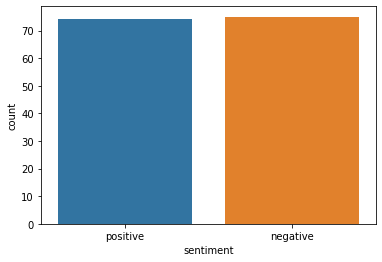

In [38]:
#checking for distribution of our target variable
sns.countplot(x='sentiment', data=dataset)

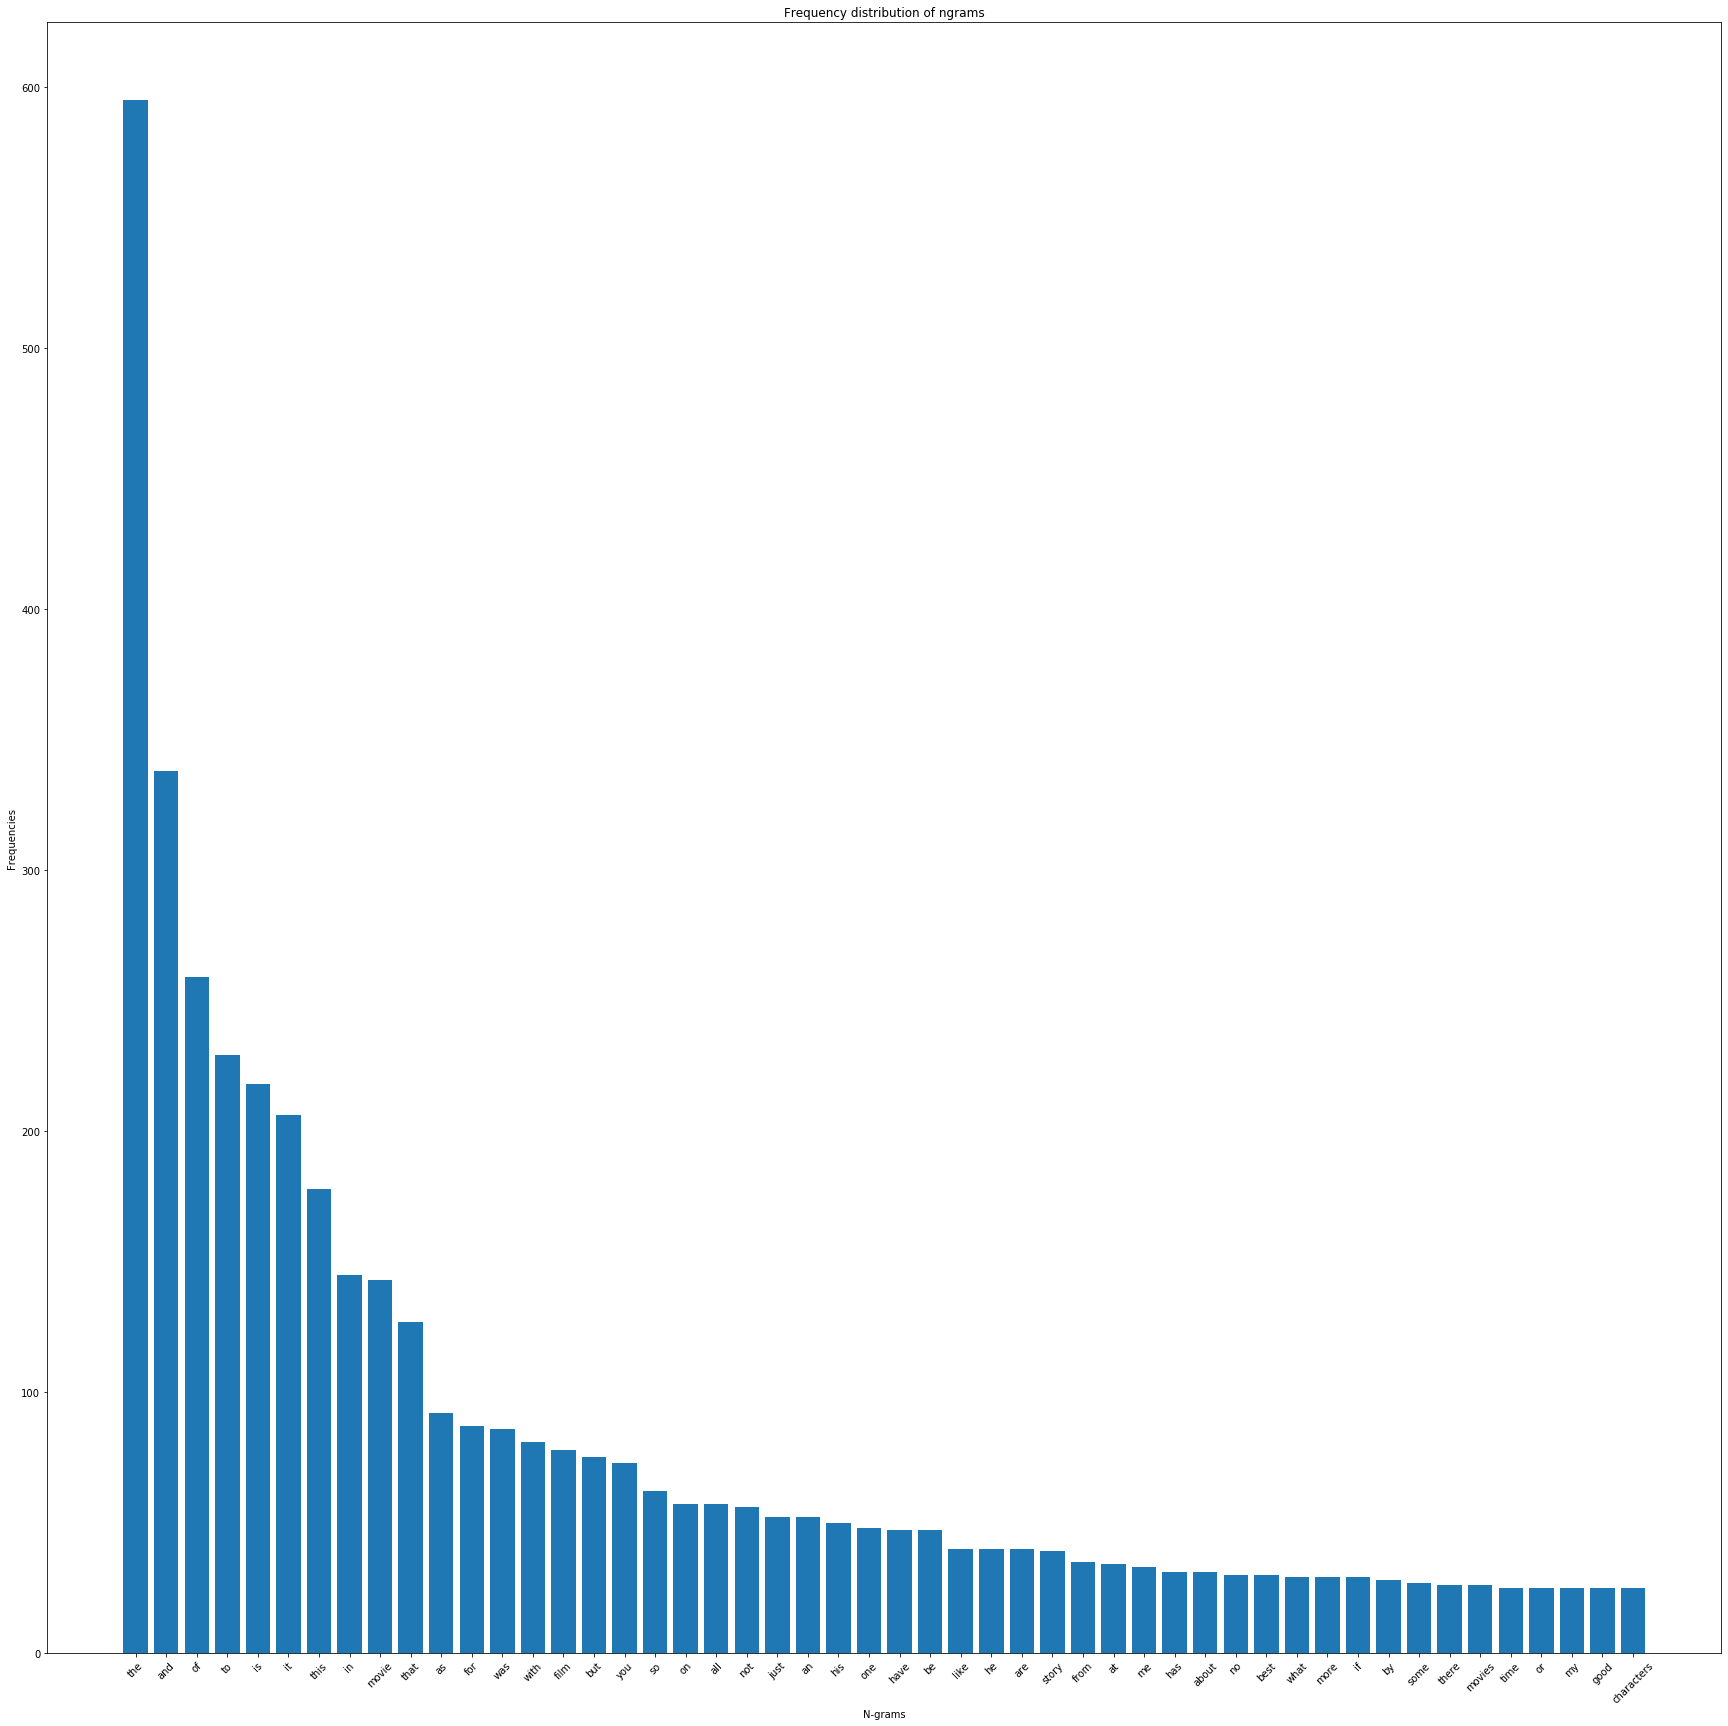

In [32]:
#checking for most repeated words
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(dataset['review']))
# ['word1', 'word2', 'word3', 'word4']
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

As seen from the bar chart above, the highest frequency words are stop - words. We will not comsider them for our analysis as they dont provide much insights about a sentiment.

# Pre-processing reviews

In [70]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocessing_text(text):
    # Remove html tag
    sentence = remove_tags(text)
    # Remove link
    sentence = re.sub(r'https:\/\/[a-zA-Z]*\.com',' ',sentence)
    # Remove number
    sentence = re.sub(r'\d+',' ',sentence)
    # Remove white space
    sentence = re.sub(r'\s+',' ',sentence)
    # Remove single character
    sentence = re.sub(r"\b[a-zA-Z]\b", ' ', sentence)
    # Remove bracket
    sentence = re.sub(r'\W+',' ',sentence)
    # Make sentence lowercase
    sentence = sentence.lower()
    return sentence

In [71]:
#pre processing sentences by removing html tags, links, white space, etc
pre_proces_sen = []
sentences = list(dataset['review'])
for sen in sentences:
    pre_proces_sen.append(preprocessing_text(sen))

In [69]:
print(pre_proces_sen[3])

not sure why so many loved this movie this movie was over hyped and the only thing about it that found fabulous were the special effects however this did not make up for the lack of emotional depth in the movie and the drawn out attempt at building suspense compared to the series of books this movie is based on the movie seems shallow and lacks cohesiveness and character development was bored and just wanted the movie to finish which is rare for me less focus on special effects and more attention to good acting and story that builds suspense would have made for better movie perhaps little more background into the character lives for example would have added lot to the overall presentation 


# Removing Stopwords

In [72]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [73]:
#this list is taken from https://www.ranks.nl/stopwords
stop = ['has', 'its', "needn't", 'm', "wouldn't", 'but', 'he', "mustn't", 'his', 'there', 'or', "won't", 'can',
        'd', "hadn't", 'how', 'hasn', 'very', 'wouldn', 'own', "doesn't", 'their', "isn't", 'an', "haven't",
        "wasn't", 'those', 'once', "shan't", 'when', "aren't", 've', 'it', "it's", 'of', "don't", 'and', 'down', 
        'yours', 'to', 'over', "she's", 'we', 'they', 'haven', 'having', 'ain', 'no', 'her', 'you', 'then', 'just',
        'didn', 'into', 'before', 'shouldn', 'here', 'yourselves', 's', 'will', 'which', 'are', 'who', 'with', "you'd", 
        'this', 'me', 'themselves', "you've", 'hadn', 'mightn', 'she', 'o', 'more', 'whom', 'for', 'him', 'again', 'below', 
        'few', 'most', 'been', 'such', 'shan', 'is', 'ourselves', 'y', 'by', 'being', 'in', 'mustn', "you'll", 'herself',
        'yourself', 'ours', 'between', 'had', 'other', "should've", 't', 'isn', 'them', 'himself', 're', 'doing', 'only',
        'where', 'your', 'after', 'so', 'll', 'against', 'the', 'about', 'each', 'aren', 'wasn', "couldn't", 'have', 'ma',
        'i', 'my', "mightn't", 'as', 'from', 'itself', 'under', 'same', 'why', 'any', 'our', 'be', 'off', "hasn't", 'through',
        "you're", 'was', 'did', "shouldn't", 'myself', 'some', 'theirs', 'hers', 'further', 'do', 'now', 'than', 'too', 
        'during', 'at', 'because', 'doesn','needn', "weren't", 'don', "didn't", 'couldn', 'what', 'does', 'if', 'up',
        'on', 'these', 'should', 'all', "that'll", 'above', 'weren', 'that', 'a', 'while', 'both', 'until', 'were', 'am']

In [74]:
#converting pre processed sentences to a vector by using word tokenizer
nltk.download('punkt')
for i in range(len(pre_proces_sen)):
    x = pre_proces_sen[i]
    x = word_tokenize(x)
    new_x_list = [word for word in x if word not in stop]
    pre_proces_sen[i] = ' '.join(new_x_list)
    if i% 10 == 0:
        print(i,end=" ")

[nltk_data] Downloading package punkt to C:\Users\Vaibhav
[nltk_data]     Gala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 

In [45]:
print(pre_proces_sen[3])

not sure many loved movie movie hyped thing found fabulous special effects however not make lack emotional depth movie drawn out attempt building suspense compared series books movie based movie seems shallow lacks cohesiveness character development bored wanted movie finish rare less focus special effects attention good acting story builds suspense would made better movie perhaps little background character lives example would added lot overall presentation


# Train | Test | Validation Split 

In [75]:
#Using k-fold cross validation to perform the split
def load_data_kfold(k):
    
    y  = dataset['sentiment']
    y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
    X = pre_proces_sen
    X_train = X
    y_train = y
    folds = list(StratifiedShuffleSplit(n_splits=k, random_state=42, train_size = 0.7).split(X_train, y_train))
    
    return folds, X_train, y_train

k = 5
folds, X_train, y_train = load_data_kfold(k)

# Tokenization

In [76]:
#creating sequence of tokenized words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [77]:
#padding the data as to make the sentences of equal length
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)


4533


# Model

In [78]:
import tensorflow as tf
from tensorflow.keras import layers
from random import shuffle
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

In [79]:
# Checkpoints
# Directory where the checkpoints will be saved
checkpoint_dir = my_temp_folder+'training_checkpoints'
import shutil
try:
    shutil.rmtree(checkpoint_dir)
except:
    print("directory not used yet.")

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='loss',
    save_weights_only=True, 
    save_best_only=True)

In [80]:
rnn_units = 128
BATCH_SIZE = 256
dropout_rate = 0.2

In [28]:
from keras import backend as K

In [82]:
#loading saved model from part 1
model = tf.keras.models.load_model('word2vec_multiLSTM.h5')
for i in range(len(model.layers)): 
    layers.trainable = False

In [111]:
#Unfolding the loaded model
model = tf.keras.models.load_model('word2vec_multiLSTM.h5')
#storing weights of input layer 
input_tensor = model.layers[0].output  
# choose how many layers you want to keep
#Appending the same layers with different parameters
h1 = layers.LSTM(64, return_sequences = True, name='LSTM_4')(input_tensor)
h2 = layers.LSTM(64, return_sequences = False, name='LSTM_5')(h1)
h3 = layers.Dropout(rate=dropout_rate)(h2)
h4 = layers.Dense(32,activation = 'relu')(h3)
h5 = layers.Dropout(rate=dropout_rate)(h4)
out = layers.Dense(1, name='dense_new_2', activation = 'sigmoid')(h5)
new_model = models.Model(model.input, outputs=out)
print("Number of layers in the base model: ", len(new_model.layers))
#Remove comment from below for loop to freeze trainable parameters
#for i in range(len(new_model.layers)): 
 #     layers.trainable = False

Number of layers in the base model:  8


In [112]:
new_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          22840200  
_________________________________________________________________
LSTM_4 (LSTM)                (None, 100, 64)           93440     
_________________________________________________________________
LSTM_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0   

In [113]:
#compiling the model
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.0001')

In [114]:
#training and validating the model using k-fold cross validation
for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    history = new_model.fit(X_train_cv, y_train_cv, epochs=10, verbose=1, shuffle=True, validation_data = (X_valid_cv,y_valid_cv))




Fold  0
Train on 104 samples, validate on 45 samples
Epoch 1/10
104/104 [==============================] - 8s 79ms/sample - loss: 0.6955 - accuracy: 0.4231 - val_loss: 0.6921 - val_accuracy: 0.5778
Epoch 2/10
104/104 [==============================] - 3s 25ms/sample - loss: 0.6854 - accuracy: 0.5481 - val_loss: 0.6903 - val_accuracy: 0.5556
Epoch 3/10
104/104 [==============================] - 3s 26ms/sample - loss: 0.6798 - accuracy: 0.5673 - val_loss: 0.6907 - val_accuracy: 0.5556
Epoch 4/10
104/104 [==============================] - 3s 26ms/sample - loss: 0.6768 - accuracy: 0.6058 - val_loss: 0.6911 - val_accuracy: 0.5556
Epoch 5/10
104/104 [==============================] - 3s 26ms/sample - loss: 0.6677 - accuracy: 0.6154 - val_loss: 0.6953 - val_accuracy: 0.5556
Epoch 6/10
104/104 [==============================] - 3s 26ms/sample - loss: 0.6508 - accuracy: 0.5769 - val_loss: 0.7167 - val_accuracy: 0.5778
Epoch 7/10
104/104 [==============================] - 3s 26ms/sample - loss:

In [115]:
#Just printing validation loss and accuracy for last epoch of last fold
score = new_model.evaluate(X_valid_cv, y_valid_cv, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.25524883998764886
Test Accuracy: 0.8666667


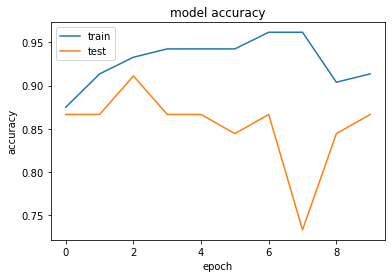

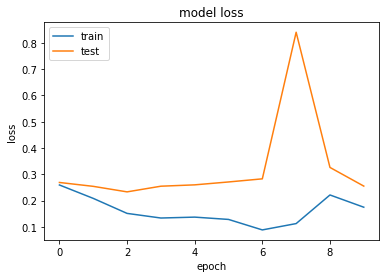

In [116]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [123]:
#saving the fine tuned model
new_model.save('fine_tuned_model_part2.h5')

In [103]:
#implementing same model from scratch
import gensim.models.keyedvectors as word2vec
from gensim.models import Word2Vec
word2vec = word2vec.KeyedVectors.load_word2vec_format('F:\Semester 2\Deep Learning\Assignment 1\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000)

In [104]:
#Assigning weights to our vocabulary from word2vec word vectors
embedding_weights = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    #embedding_vector = word2vec.get(word)
    try:
        embedding_weights[index] = word2vec[word]
    except:
        pass 

In [117]:
#using pre - trained embedding on multi LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_weights],
                                     trainable = False))
model.add(tf.keras.layers.LSTM(64,return_sequences = True))
model.add(tf.keras.layers.LSTM(64,return_sequences = False))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(32,activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [118]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          1359900   
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 64)           93440     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [119]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.0001')

In [120]:
#training and validating the model using k-fold cross validation
for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    history = model.fit(X_train_cv, y_train_cv, epochs=10, verbose=1,shuffle=True, validation_data = (X_valid_cv,y_valid_cv))


Fold  0
Train on 104 samples, validate on 45 samples
Epoch 1/10
104/104 [==============================] - 5s 52ms/sample - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5778
Epoch 2/10
104/104 [==============================] - 2s 21ms/sample - loss: 0.6817 - accuracy: 0.6154 - val_loss: 0.6911 - val_accuracy: 0.5778
Epoch 3/10
104/104 [==============================] - 2s 22ms/sample - loss: 0.6773 - accuracy: 0.5096 - val_loss: 0.6881 - val_accuracy: 0.5778
Epoch 4/10
104/104 [==============================] - 2s 21ms/sample - loss: 0.6572 - accuracy: 0.6538 - val_loss: 0.6785 - val_accuracy: 0.5778
Epoch 5/10
104/104 [==============================] - 2s 22ms/sample - loss: 0.6126 - accuracy: 0.7019 - val_loss: 0.6872 - val_accuracy: 0.5556
Epoch 6/10
104/104 [==============================] - 2s 22ms/sample - loss: 0.5797 - accuracy: 0.7115 - val_loss: 0.5960 - val_accuracy: 0.6667
Epoch 7/10
104/104 [==============================] - 2s 22ms/sample - loss:

In [121]:
#Just printing validation loss and accuracy for last epoch of last fold
score = model.evaluate(X_valid_cv, y_valid_cv, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.10847046019302474
Test Accuracy: 0.9777778


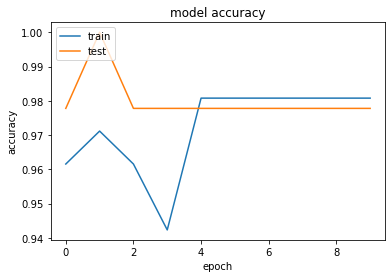

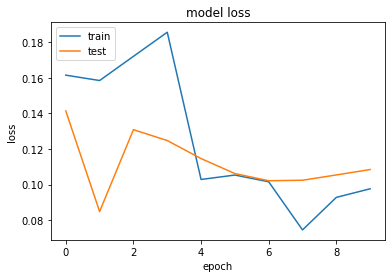

In [122]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()